In [23]:
from NinaPro_Utility import *

import tensorflow.compat.v1 as tf

tf.config.set_soft_device_placement(True)
tf.debugging.set_log_device_placement(True)
from sklearn.metrics import confusion_matrix
import numpy as np
from scipy.io import loadmat
import os
from functools import reduce
from scipy import signal
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from tensorflow import keras as K
from tensorflow.keras.layers import Dense, Activation, Flatten, concatenate, Input, Dropout, LSTM, Bidirectional, InputLayer
from tensorflow.keras.models import Sequential, Model, load_model
from keras import Sequential, optimizers, callbacks
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
%matplotlib inline

In [3]:
# import os
# import scipy.io
# import pandas as pd

# Carregar o arquivo .mat
#data = scipy.io.loadmat("Databases/NinaproDB2/DB2_s1/S1_E1_A1.mat")
#data2 = scipy.io.loadmat("db1/S1_A1_E1.mat")

data = get_data("C:/Users/PC/Desktop/TCC_Folders/TCC_code/teste/Databases/NinaproDB2/DB2_s1/","S1_E1_A1.mat")


In [4]:
data.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,stimulus,repetition
count,1.808331e+06,1.808331e+06,1.808331e+06,1.808331e+06,1.808331e+06,1.808331e+06,1.808331e+06,1.808331e+06,1.808331e+06,1.808331e+06,1.808331e+06,1.808331e+06,1.808331e+06,1.808331e+06
mean,4.808208e-09,-7.357209e-10,-4.197119e-07,2.112322e-09,-1.398447e-10,8.477198e-10,2.029853e-09,2.024880e-08,9.771656e-09,-4.893328e-07,2.336828e-09,7.045426e-09,3.386753e+00,2.180416e+00
std,4.115429e-05,2.760299e-05,4.324342e-05,4.576067e-05,1.159764e-05,1.033350e-05,4.762980e-05,7.486290e-05,4.731058e-05,5.242014e-05,7.782818e-06,3.717509e-05,5.210184e+00,2.165587e+00
min,-1.414742e-03,-1.417531e-03,-5.499916e-03,-1.693960e-03,-3.886087e-04,-2.764023e-04,-1.990281e-03,-1.453127e-03,-1.497044e-03,-1.662379e-03,-1.226652e-04,-4.916440e-04,0.000000e+00,0.000000e+00
25%,-4.978786e-06,-3.936091e-06,-3.251690e-06,-2.873654e-06,-2.693712e-06,-2.851705e-06,-5.523253e-06,-5.870371e-06,-3.371552e-06,-8.236710e-06,-2.273728e-06,-7.771074e-06,0.000000e+00,0.000000e+00
50%,1.466555e-07,3.258234e-07,6.282035e-09,8.234291e-08,7.752094e-08,1.029062e-07,1.287111e-06,8.321901e-07,-1.532981e-07,-9.468358e-07,-6.239010e-08,-7.593062e-07,0.000000e+00,2.000000e+00
75%,5.056879e-06,4.663832e-06,3.371931e-06,3.101591e-06,2.885123e-06,3.037450e-06,8.765568e-06,1.014123e-05,2.954850e-06,6.279086e-06,2.107727e-06,4.587339e-06,6.000000e+00,4.000000e+00
max,1.247256e-03,5.895796e-04,5.498070e-03,2.179232e-03,3.563007e-04,3.291671e-04,1.541105e-03,1.005659e-03,1.201373e-03,2.007309e-03,2.103748e-04,8.960569e-04,1.700000e+01,6.000000e+00


In [5]:
train_reps = [1,3,4,6]
test_reps = [2,5]

data = normalise(data, train_reps)


In [6]:
emg_low = filter_data(data=data, f=20, butterworth_order=4, btype='lowpass') 
emg_band = filter_data(data=data, f=(20,40), butterworth_order=4, btype='bandpass') 
emg_high = filter_data(data=data, f=20, butterworth_order=4, btype='high') 

In [ ]:
emg_low.head()

In [ ]:
emg_low[:1000].plot(figsize = (15,10))

<Axes: >

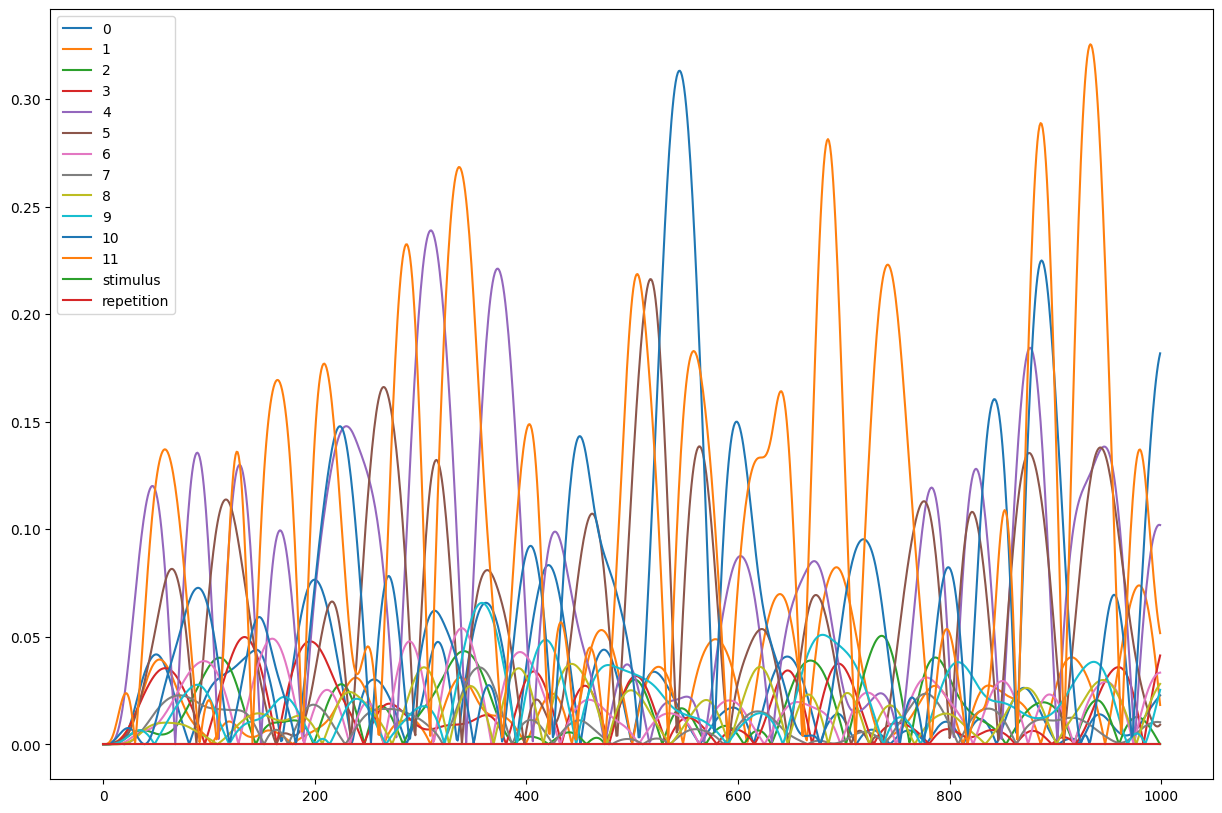

In [7]:
emg_rectified = rectify(emg_low)
emg_rectified[:1000].plot(figsize = (15,10))

In [8]:
np.unique(data.stimulus)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17], dtype=int8)

In [9]:
gestures = [i for i in range(1,18)]

In [10]:
win_len = 250
win_stride = 50


In [11]:
X_train, y_train, r_train = windowing(emg_low, train_reps, gestures, win_len, win_stride)

In [12]:
X_test, y_test, r_test = windowing(emg_low, test_reps, gestures, win_len, win_stride)

In [13]:
y_train = get_categorical(y_train)
y_test = get_categorical(y_test)

In [24]:
# from tensorflow.keras.layers import Dense, Activation, Flatten, concatenate, Input, Dropout, LSTM, Bidirectional
def get_model(X_train):
    # nodes = X_train.shape[1]
    
    # inputs = Input(shape=(nodes,12))    
    # LSTM_1 = LSTM(nodes, dropout=0.2, return_sequences=True)(inputs)
    # LSTM_2 = LSTM(nodes, dropout=0.2, return_sequences=True)(LSTM_1)    
    # LSTM_3 = LSTM(nodes, dropout=0.2, return_sequences=True)(LSTM_2)
    # LSTM_4 = LSTM(nodes, dropout=0.2, return_sequences=True)(LSTM_3)
          
    model = Sequential()

    model.add(InputLayer(input_shape = (40,10)))
    model.add(Dense(400))
    model.add(Bidirectional(LSTM(1000, return_sequences = True)))
    model.add(Dropout(0.4))
    model.add(Bidirectional(LSTM(1000)))
    model.add(Dropout(0.4))
    model.add(Dense(15, activation='softmax'))
    
    return model

In [29]:


model = get_model(X_train)

def scheduler(epoch):
  if epoch < 50:
    lr =0.001
  elif 50 <= epoch <100:
    lr =0.0005
  elif 100 <= epoch <150:
    lr =0.0001
  elif epoch >= 150:
    lr =0.00001

  return lr 

Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FloorMod in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Cast in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StatelessRandomGetKeyCounter in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op StatelessRandomUniformV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Sub in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AddV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /j

In [30]:
model.compile(optimizer= optimizers.Adam(learning_rate= 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
callback = callbacks.LearningRateScheduler(scheduler) #implement stepwise learning rate
#histories, model = train_model(model, X_train, y_train, X_test, y_test, save_to= 'temp.keras', epoch=300)

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Fill in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0


In [31]:
history = model.fit(X_train,y_train, epochs=125,validation_data=(X_test,y_test), verbose=1, callbacks=[callback], batch_size = 32)

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op _EagerConst in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDatasetV2 in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op OptionsDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op Pr

ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_7" is incompatible with the layer: expected axis -1 of input shape to have value 10, but received input with shape (None, 250, 12)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 250, 12), dtype=float32)
  • training=True
  • mask=None

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import time

#instantiate LDA classifier 
LDA = LinearDiscriminantAnalysis(solver = "svd")    

#define subject datasets to evaluate 
subjects = [1]

#define lists to store data accumulated across multiple subjects
acc = []
all_train_time = []
all_test_times = []

#iterate through subjects 
for subject in subjects:
    
    #retreive input sEMG feature data and target labels from CSV files
    inputs, targets = featinputstargets(subject,"train") 
    val_inputs, val_targets = featinputstargets(subject,"validation") 
    test_inputs, test_targets = featinputstargets(subject,"test")

    #start timer 
    start_time = time.time()

    #fit LDA model to training data 
    LDA.fit(inputs,targets)

    #calculate training time 
    train_time = (time.time() - start_time)

    #use LDA to classify test data
    tpred = LDA.predict(test_inputs)  #this was changed to val_inputs during validation

    #calculate test time 
    test_time = (time.time() - train_time -start_time)

    #store time values in appropriate lists 
    all_train_time.append(train_time)
    all_test_times.append(test_time)

    #evaulate LDA performance on test data set
    tscore = []
    for i, sample in enumerate(test_inputs):
        #check if the LDA classification was correct
        if round(tpred[i]) == test_targets[i]:  #this was changed to val_targets during validation
            tscore.append(1)
        else:
            tscore.append(0)
    pass

    # calculate the accuracy of LDA on test set
    score = np.asarray(tscore)
    test_acc = score.sum() / score.size * 100
    print("test accuracy:", test_acc)
    
    #create and display confusion matrix
    cm = confusion_matrix(test_targets, tpred)
    display = "0", "1", "2","3","4","5","6","7","8","9","10","11","12","13","14"
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display)
    disp.plot(cmap="Blues")

    #create classification report 
    cr = classification_report(test_targets,tpred)
    print(cr)
    plt.show()
    
    #add specific subject accuracy to list
    acc.append(test_acc)

#calculate average classification accuracy     
acc = np.array(acc)
totalaccuracy = np.mean(acc)
print("avg:",totalaccuracy,"values:",acc)

#calculate average and cumulative train and test times 
all_train_time = np.array(all_train_time)
all_test_times = np.array(all_test_times)

avg_train = np.mean(all_train_time)
avg_test = np.mean(all_test_times)

cum_train = np.sum(all_train_time)
cum_test = np.sum(all_test_times)

print("train times", all_train_time)
print("test times", all_test_times)

print(" avg.train times", avg_train)
print("avg. test times", avg_test)

print(" cum.train times", cum_train)
print("cum. test times", cum_test)